# Heart Disease Prediction (Imbalanced Data)
## Advanced Classification Project

### 1. Problem Statement
- Predict the presence of heart disease in patients using clinical features.
- Address class imbalance and optimize classification thresholds.

### 2. Setup

 - Importing packages

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 

 - Importing the Dataset

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
# merging dataset
dataset = pd.concat([X,y], axis=1)

 - Method for evaluating the model

In [3]:
def evaluate(model, X_test, y_test):
    """
    Evaluate a classification model's performance using common metrics.
    
    Parameters:
    -----------
    model : classifier
        Trained classification model implementing `predict()` method
    X_test : array-like or DataFrame
        Feature matrix of test data
    y_test : array-like or Series
        True target values for test data
        
    Returns:
    --------
    dict
        Dictionary containing performance metrics (as percentages)
    """
    y_pred = model.predict(X_test)
    
    # Use macro/micro averaging for multiclass
    avg_method = 'macro'  # or 'micro'/'weighted'
    
    return {
        # Use round(value, decimals) instead of value.round()
        'Accuracy': round(100 * accuracy_score(y_test, y_pred), 2),
        'Precision': round(100 * precision_score(y_test, y_pred, average=avg_method), 2),
        'Recall': round(100 * recall_score(y_test, y_pred, average=avg_method), 2),
        'F1 Score': round(100 * f1_score(y_test, y_pred, average=avg_method), 2),
        'Roc_Auc': round(100 * roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo'), 2)
    }

### 3. Cleaning the dataset

 - Removing any null value

In [4]:
((dataset.isnull().sum()/ len(dataset)) * 100).round(2)

age         0.00
sex         0.00
cp          0.00
trestbps    0.00
chol        0.00
fbs         0.00
restecg     0.00
thalach     0.00
exang       0.00
oldpeak     0.00
slope       0.00
ca          1.32
thal        0.66
num         0.00
dtype: float64

In [5]:
dataset.dropna(subset=['ca','thal'], how = 'any', axis = 0, inplace = True)
((dataset.isnull().sum()/ len(dataset)) * 100).round(2)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
num         0.0
dtype: float64

- Splitting the Dataset into test and train

In [6]:
X = dataset.drop(['num'], axis = 1)
y = dataset['num']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42  # Optional: for reproducibility
)

### 4. Training Models

#### **Baseline**: Without fixing imbalance

**Logistic Regression**

In [7]:
LR_model = LogisticRegression()
LR_model.fit(X_train,y_train)

/Users/SaadMakki/Developer/Python/Projects/Heart-Disease-Prediction-Imbalanced-Data/myevn/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

**RandomForestClassifier**

In [8]:
RFC_model = RandomForestClassifier()
RFC_model.fit(X_train,y_train)

RandomForestClassifier()

**XGBClassifier**

In [9]:
XGB_model = XGBClassifier()
XGB_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [10]:
evaluate(LR_model, X_test, y_test)

/Users/SaadMakki/Developer/Python/Projects/Heart-Disease-Prediction-Imbalanced-Data/myevn/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 66.67,
 'Precision': 33.48,
 'Recall': 32.97,
 'F1 Score': 32.78,
 'Roc_Auc': np.float64(65.67)}

In [11]:
evaluate(RFC_model, X_test, y_test)

{'Accuracy': 60.0,
 'Precision': 19.61,
 'Recall': 23.44,
 'F1 Score': 21.36,
 'Roc_Auc': np.float64(62.76)}

In [12]:
evaluate(XGB_model, X_test, y_test)

{'Accuracy': 58.33,
 'Precision': 30.32,
 'Recall': 30.19,
 'F1 Score': 29.64,
 'Roc_Auc': np.float64(62.67)}

#### **Improved**: With SMOTE

In [13]:
smote = SMOTE(random_state = 42)
X_reshaped, y_reshaped = smote.fit_resample(X_train, y_train)

In [14]:
LR_model.fit(X_reshaped,y_reshaped)
evaluate(LR_model, X_test, y_test)

/Users/SaadMakki/Developer/Python/Projects/Heart-Disease-Prediction-Imbalanced-Data/myevn/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Accuracy': 65.0,
 'Precision': 41.5,
 'Recall': 38.16,
 'F1 Score': 39.03,
 'Roc_Auc': np.float64(63.33)}

In [15]:
RFC_model.fit(X_reshaped,y_reshaped)
evaluate(RFC_model, X_test, y_test)

{'Accuracy': 58.33,
 'Precision': 30.92,
 'Recall': 32.08,
 'F1 Score': 30.22,
 'Roc_Auc': np.float64(60.43)}

In [16]:
XGB_model.fit(X_reshaped,y_reshaped)
evaluate(XGB_model, X_test, y_test)

{'Accuracy': 53.33,
 'Precision': 25.39,
 'Recall': 23.41,
 'F1 Score': 24.02,
 'Roc_Auc': np.float64(63.13)}

## Adding Visualization 

### 1. Setup and Data Preparation

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, roc_auc_score,
                            confusion_matrix, ConfusionMatrixDisplay,
                            classification_report)
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# Initialize plot settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Fetch and clean data
heart_disease = fetch_ucirepo(id=45)
dataset = pd.concat([heart_disease.data.features, heart_disease.data.targets], axis=1)
dataset.dropna(subset=['ca', 'thal'], inplace=True)
X = dataset.drop('num', axis=1)
y = dataset['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Comprehensive Visualization

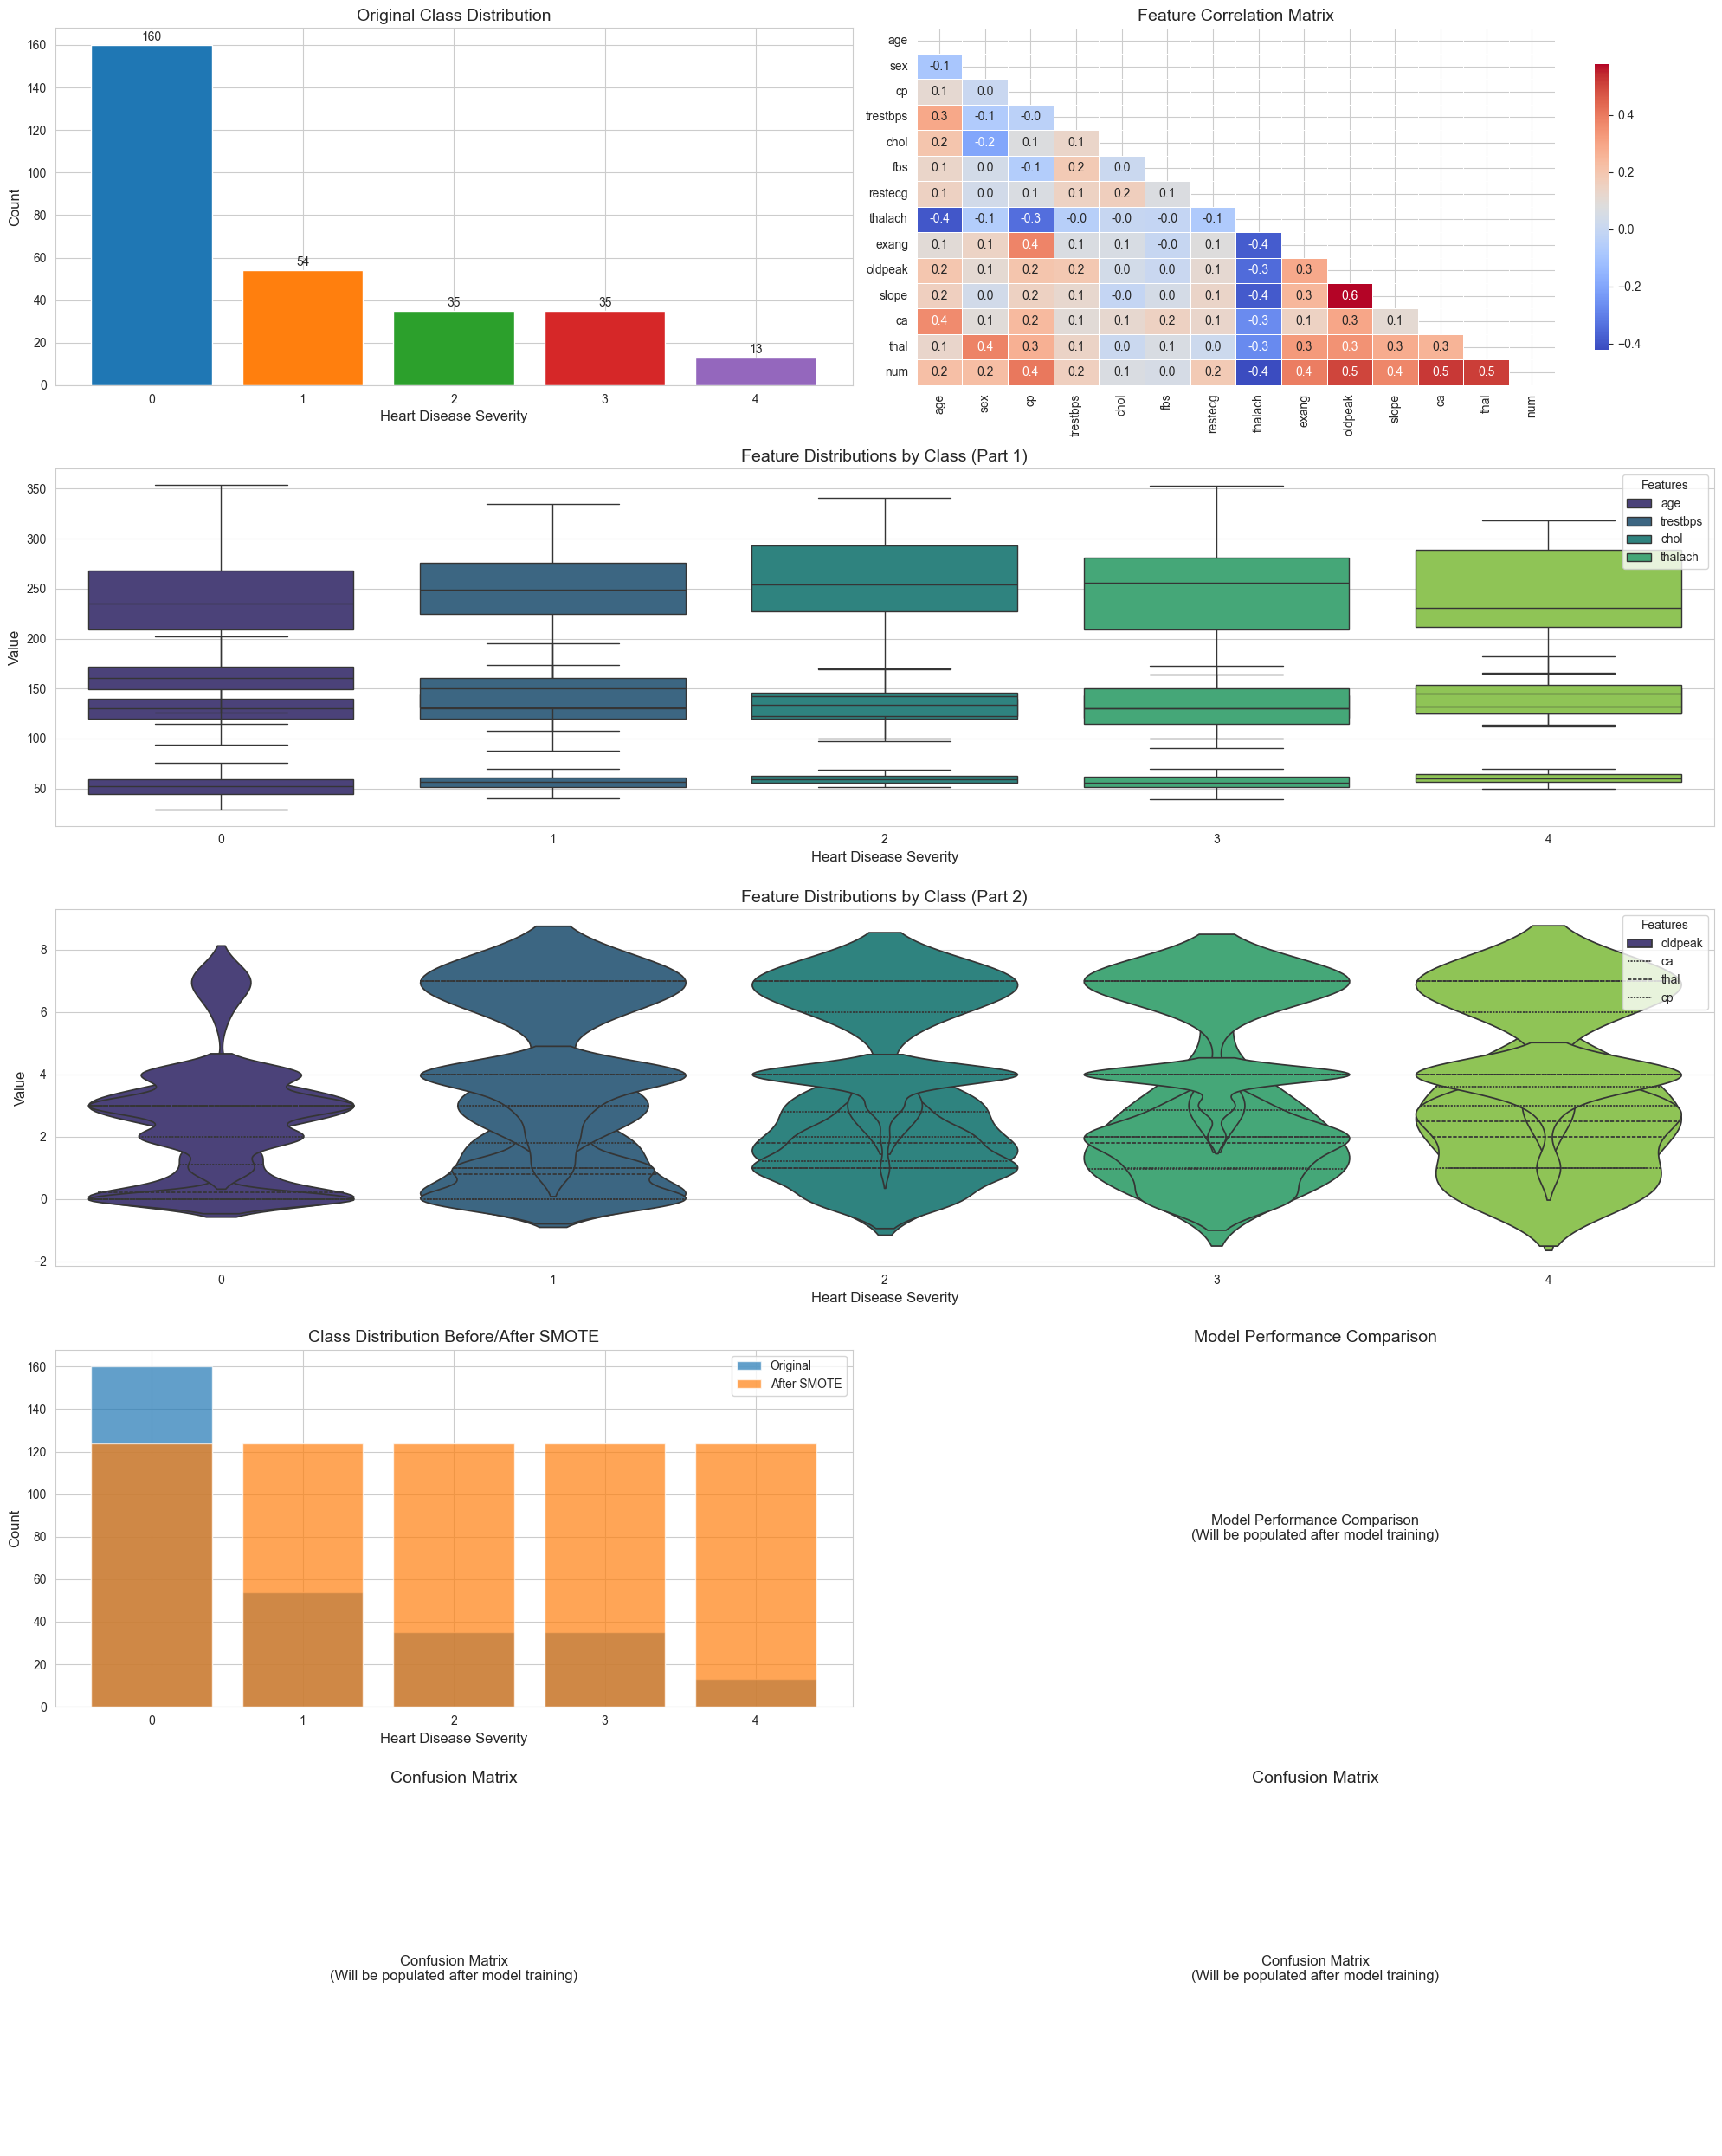

In [21]:
# Create figure with subplots
fig = plt.figure(figsize=(20, 25))
gs = fig.add_gridspec(5, 2)
ax1 = fig.add_subplot(gs[0, 0])  # Class distribution
ax2 = fig.add_subplot(gs[0, 1])  # Correlation matrix
ax3 = fig.add_subplot(gs[1, :])  # Feature distributions (row 1)
ax4 = fig.add_subplot(gs[2, :])  # Feature distributions (row 2)
ax5 = fig.add_subplot(gs[3, 0])  # SMOTE comparison
ax6 = fig.add_subplot(gs[3, 1])  # Model comparison
ax7 = fig.add_subplot(gs[4, 0])  # Confusion matrix 1
ax8 = fig.add_subplot(gs[4, 1])  # Confusion matrix 2

# 1. Class Distribution
class_counts = y.value_counts().sort_index()
ax1.bar(class_counts.index.astype(str), class_counts, color=colors)
ax1.set_title('Original Class Distribution', fontsize=14)
ax1.set_xlabel('Heart Disease Severity', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
for i, count in enumerate(class_counts):
    ax1.text(i, count+2, str(count), ha='center', fontsize=10)

# 2. Correlation Matrix
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, ax=ax2, cmap='coolwarm', annot=True, fmt=".1f", 
            cbar_kws={"shrink": 0.8}, linewidths=0.5)
ax2.set_title('Feature Correlation Matrix', fontsize=14)

# 3. Feature Distributions (Row 1)
features1 = ['age', 'trestbps', 'chol', 'thalach']
for i, feature in enumerate(features1):
    sns.boxplot(x='num', y=feature, data=dataset, ax=ax3, 
                palette='viridis', showfliers=False)
ax3.set_title('Feature Distributions by Class (Part 1)', fontsize=14)
ax3.set_xlabel('Heart Disease Severity')
ax3.set_ylabel('Value')
ax3.legend(title='Features', labels=features1, loc='upper right')

# 4. Feature Distributions (Row 2)
features2 = ['oldpeak', 'ca', 'thal', 'cp']
for i, feature in enumerate(features2):
    sns.violinplot(x='num', y=feature, data=dataset, ax=ax4, 
                   palette='viridis', inner="quartile")
ax4.set_title('Feature Distributions by Class (Part 2)', fontsize=14)
ax4.set_xlabel('Heart Disease Severity')
ax4.set_ylabel('Value')
ax4.legend(title='Features', labels=features2, loc='upper right')

# 5. SMOTE Comparison
smote = SMOTE(random_state=42)
X_reshaped, y_reshaped = smote.fit_resample(X_train, y_train)
smote_counts = y_reshaped.value_counts().sort_index()

ax5.bar(class_counts.index.astype(str), class_counts, color=colors[0], alpha=0.7, label='Original')
ax5.bar(smote_counts.index.astype(str), smote_counts, color=colors[1], alpha=0.7, label='After SMOTE')
ax5.set_title('Class Distribution Before/After SMOTE', fontsize=14)
ax5.set_xlabel('Heart Disease Severity', fontsize=12)
ax5.set_ylabel('Count', fontsize=12)
ax5.legend()

# 6. Model Comparison (Placeholder - will be updated later)
ax6.text(0.5, 0.5, 'Model Performance Comparison\n(Will be populated after model training)', 
         ha='center', va='center', fontsize=12)
ax6.set_title('Model Performance Comparison', fontsize=14)
ax6.axis('off')

# 7. & 8. Confusion Matrices (Placeholders)
for ax in [ax7, ax8]:
    ax.text(0.5, 0.5, 'Confusion Matrix\n(Will be populated after model training)', 
            ha='center', va='center', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.savefig('all_visualizations.png', bbox_inches='tight')
plt.show()

### 3. Model Training and Evaluation

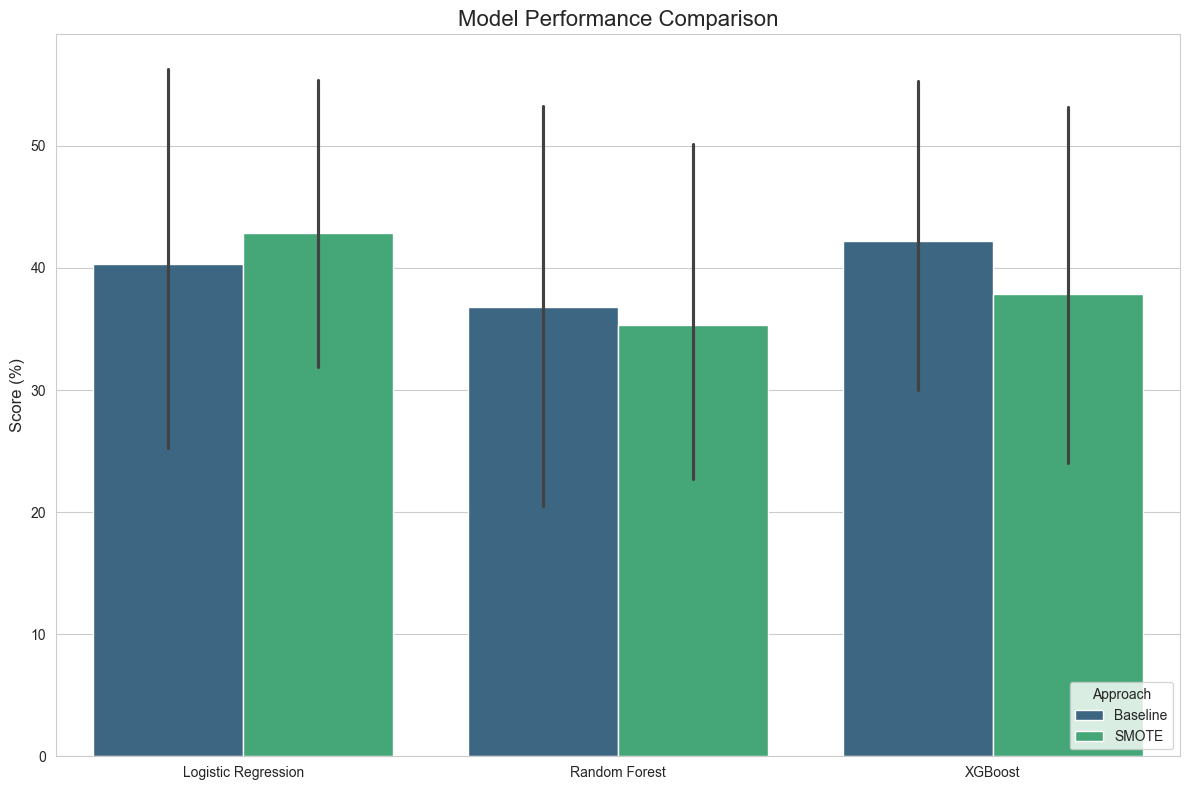

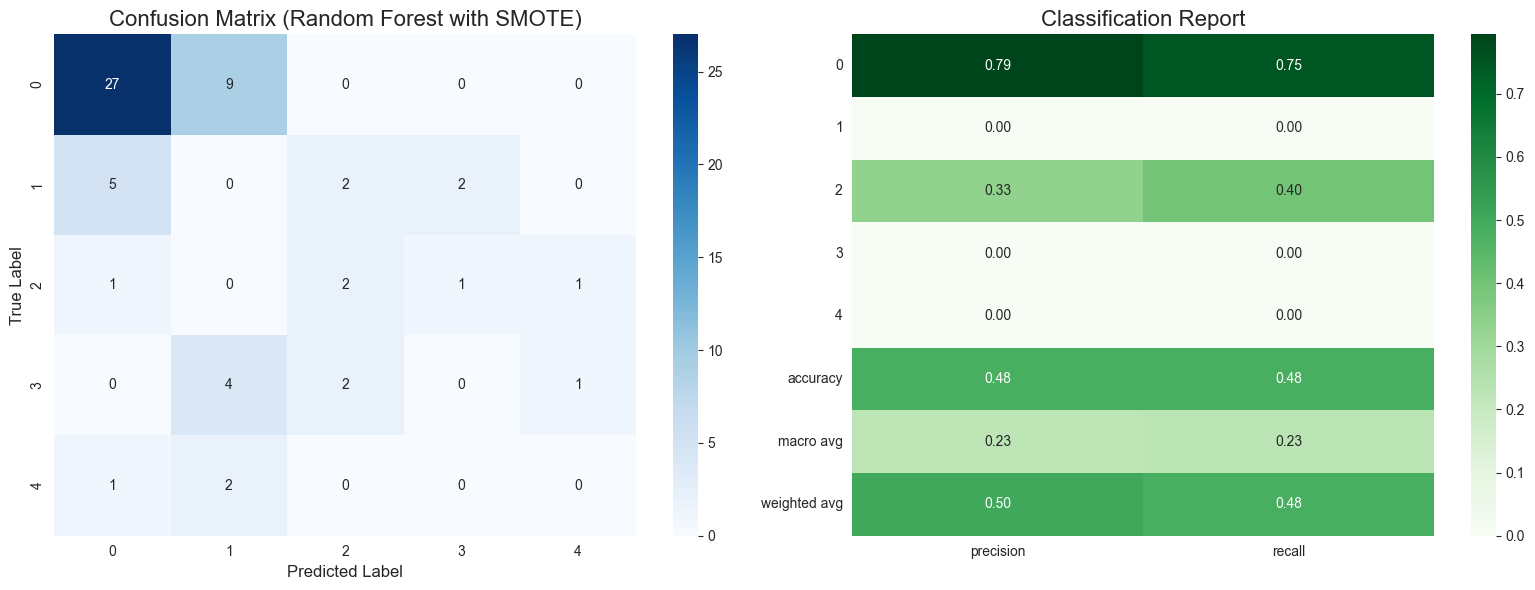

Model Performance Comparison:


,Model,Approach,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,Baseline,60.00,26.12,25.11,24.86,65.50
1,Random Forest,Baseline,60.00,18.77,23.44,20.83,60.96
2,XGBoost,Baseline,58.33,30.32,30.19,29.64,62.67
3,Logistic Regression,SMOTE,55.00,31.81,32.52,31.59,63.43
4,Random Forest,SMOTE,48.33,22.55,23.00,22.70,59.99
5,XGBoost,SMOTE,53.33,25.39,23.41,24.02,63.13


In [20]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Evaluation function
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    avg_method = 'macro'
    return {
        'Accuracy': round(100 * accuracy_score(y_test, y_pred), 2),
        'Precision': round(100 * precision_score(y_test, y_pred, average=avg_method, zero_division=0), 2),
        'Recall': round(100 * recall_score(y_test, y_pred, average=avg_method), 2),
        'F1 Score': round(100 * f1_score(y_test, y_pred, average=avg_method), 2),
        'ROC AUC': round(100 * roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo'), 2)
    }

# Train and evaluate baseline models
baseline_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    baseline_results[name] = evaluate(model, X_test, y_test)

# Train and evaluate SMOTE models
smote_results = {}
for name, model in models.items():
    model.fit(X_reshaped, y_reshaped)
    smote_results[name] = evaluate(model, X_test, y_test)

# Generate performance comparison
results_df = pd.DataFrame({
    'Model': list(models.keys()) * 2,
    'Approach': ['Baseline'] * 3 + ['SMOTE'] * 3,
    'Accuracy': [baseline_results[m]['Accuracy'] for m in models] + [smote_results[m]['Accuracy'] for m in models],
    'Precision': [baseline_results[m]['Precision'] for m in models] + [smote_results[m]['Precision'] for m in models],
    'Recall': [baseline_results[m]['Recall'] for m in models] + [smote_results[m]['Recall'] for m in models],
    'F1 Score': [baseline_results[m]['F1 Score'] for m in models] + [smote_results[m]['F1 Score'] for m in models],
    'ROC AUC': [baseline_results[m]['ROC AUC'] for m in models] + [smote_results[m]['ROC AUC'] for m in models]
})

# Update model comparison plot
fig, ax = plt.subplots(figsize=(12, 8))
results_pivot = results_df.melt(id_vars=['Model', 'Approach'], 
                                var_name='Metric', 
                                value_name='Score')

sns.barplot(x='Model', y='Score', hue='Approach', 
            data=results_pivot, palette='viridis', ax=ax)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_ylabel('Score (%)')
ax.set_xlabel('')
plt.legend(title='Approach', loc='lower right')
plt.tight_layout()
plt.savefig('model_comparison.png', bbox_inches='tight')
plt.show()

# Generate confusion matrices for best model
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_reshaped, y_reshaped)
y_pred = best_model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix (Random Forest with SMOTE)')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df.iloc[:, :-1].astype(float), annot=True, fmt='.2f', cmap='Greens', ax=ax2)
ax2.set_title('Classification Report')
plt.tight_layout()
plt.savefig('confusion_matrix_report.png', bbox_inches='tight')
plt.show()

# Print performance comparison table
print("Model Performance Comparison:")
display(results_df)